In [16]:
import pandas as pd
import numpy as np

In [30]:
result_path = '/home/jibeiroa/desercion_escolar_argentina/models/results_unsampled.csv'
results = pd.read_csv(result_path)

In [31]:
results

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__class_weight,param_classifier__n_neighbors,param_classifier__max_depth,...,param_classifier__estimator__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0,1.292413,0.166776,0.388949,0.040563,"LogisticRegression(penalty='l1', solver='libli...",1.000000e-10,"{0: 0.0, 1: 0.0}",NaN,NaN,...,NaN,{'classifier': LogisticRegression(penalty='l1'...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1145
1,1,1.291707,0.278013,0.393169,0.031810,"LogisticRegression(penalty='l1', solver='libli...",1.000000e-10,"{0: 0.06458345553013861, 1: 0.3974312699272093}",NaN,NaN,...,NaN,{'classifier': LogisticRegression(penalty='l1'...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1145
2,2,1.167003,0.180620,0.306922,0.009245,"LogisticRegression(penalty='l1', solver='libli...",1.000000e-10,"{0: 0.12916691106027722, 1: 0.7948625398544186}",NaN,NaN,...,NaN,{'classifier': LogisticRegression(penalty='l1'...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1145
3,3,1.099967,0.069907,0.313389,0.028585,"LogisticRegression(penalty='l1', solver='libli...",1.000000e-10,"{0: 0.19375036659041583, 1: 1.1922938097816278}",NaN,NaN,...,NaN,{'classifier': LogisticRegression(penalty='l1'...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1145
4,4,1.112322,0.081734,0.302332,0.012325,"LogisticRegression(penalty='l1', solver='libli...",1.000000e-10,"{0: 0.25833382212055445, 1: 1.5897250797088371}",NaN,NaN,...,NaN,{'classifier': LogisticRegression(penalty='l1'...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,1609,2.204056,0.086188,0.339969,0.035320,BaggingClassifier(estimator=DecisionTreeClassi...,NaN,NaN,NaN,NaN,...,36.0,{'classifier': BaggingClassifier(estimator=Dec...,0.092141,0.086486,0.105405,0.108401,0.108401,0.100167,0.009106,843
1610,1610,2.431138,0.111719,0.321688,0.012819,BaggingClassifier(estimator=DecisionTreeClassi...,NaN,NaN,NaN,NaN,...,36.0,{'classifier': BaggingClassifier(estimator=Dec...,0.070461,0.102703,0.102703,0.070461,0.078591,0.084984,0.014769,983
1611,1611,2.483062,0.030226,0.360578,0.044480,BaggingClassifier(estimator=DecisionTreeClassi...,NaN,NaN,NaN,NaN,...,36.0,{'classifier': BaggingClassifier(estimator=Dec...,0.116531,0.075676,0.072973,0.089431,0.102981,0.091518,0.016470,943
1612,1612,2.762781,0.133147,0.364307,0.036369,BaggingClassifier(estimator=DecisionTreeClassi...,NaN,NaN,NaN,NaN,...,36.0,{'classifier': BaggingClassifier(estimator=Dec...,0.094851,0.067568,0.081081,0.078591,0.097561,0.083930,0.011040,984


In [33]:
results[results.rank_test_score == 1]

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__class_weight,param_classifier__n_neighbors,param_classifier__max_depth,...,param_classifier__estimator__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
552,552,1.235393,0.092937,0.307069,0.033245,DecisionTreeClassifier(),NaN,"{0: 0.12916691106027722, 1: 0.7948625398544186}",NaN,8.0,...,NaN,"{'classifier': DecisionTreeClassifier(), 'clas...",0.737127,0.686486,0.735135,0.693767,0.631436,0.69679,0.038688,1


In [21]:
np.logspace(-3, -2, 25)

array([0.001     , 0.00110069, 0.00121153, 0.00133352, 0.0014678 ,
       0.0016156 , 0.00177828, 0.00195734, 0.00215443, 0.00237137,
       0.00261016, 0.00287298, 0.00316228, 0.0034807 , 0.00383119,
       0.00421697, 0.00464159, 0.00510897, 0.00562341, 0.00618966,
       0.00681292, 0.00749894, 0.00825404, 0.00908518, 0.01      ])

In [24]:
n_samples = len(train_data.DESERTO)
n_classes = train_data.DESERTO.nunique()
balanced = n_samples / (n_classes * np.bincount(train_data.DESERTO))
weights = np.linspace(0.01, balanced, 10)
[{0: x[0], 1: balanced[1]-x[1]} for x in weights][:-1]

[{0: 0.01, 1: 3.5668814293448836},
 {0: 0.0734723444190275, 1: 3.1705612705287853},
 {0: 0.13694468883805502, 1: 2.774241111712687},
 {0: 0.20041703325708254, 1: 2.377920952896589},
 {0: 0.26388937767611004, 1: 1.9816007940804907},
 {0: 0.32736172209513753, 1: 1.5852806352643924},
 {0: 0.3908340665141651, 1: 1.1889604764482948},
 {0: 0.4543064109331926, 1: 0.7926403176321966},
 {0: 0.5177787553522201, 1: 0.3963201588160983}]

In [6]:
import os

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt

from desercion_escolar_argentina.utils import file_handler as fh
from desercion_escolar_argentina.artifacts import imputer as im
from desercion_escolar_argentina.artifacts import scaler as sc
from desercion_escolar_argentina.artifacts import encoder as enc

In [7]:
id_cols = [
    'CODUSU', 'NRO_HOGAR', 'COMPONENTE', 'ANO4', 'TRIMESTRE', 'PONDERA'
]

repo_path = fh.get_repo_path()
train_path = os.path.join(repo_path, 'data/preprocessed/', 'preprocessed_train.csv')
test_path = os.path.join(repo_path, 'data/preprocessed/', 'preprocessed_test.csv')
train_data = pd.read_csv(train_path)
train_data = train_data.loc[:, ~train_data.columns.isin(id_cols)]
test_data = pd.read_csv(test_path)
test_data = test_data.loc[:, ~test_data.columns.isin(id_cols)]


X_train = train_data.loc[:, train_data.columns != 'DESERTO']
y_train = train_data.loc[:, train_data.columns == 'DESERTO'].values.ravel()

X_test = test_data.loc[:, test_data.columns != 'DESERTO']
y_test = test_data.loc[:, test_data.columns == 'DESERTO'].values.ravel()

Mejor modelo: 
Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('knnimputer-1',
                                                  KNNImputer(missing_values=9.0,
                                                             n_neighbors=1),
                                                  ['CH07', 'CH08', 'CH11', 'V1',
                                                   'V2', 'V3', 'V5', 'V6', 'V7',
                                                   'V8', 'V11', 'V12', 'V13',
                                                   'V14', 'PP07I_jefx']),
                                                 ('knnimputer-2',
                                                  KNNImputer(missing_values=99.0,
                                                             n_neighbors=1),
                                                  ['IV2', 'II1']),
                                                 ('knnimputer-3',
 

/home/jibeiroa/.cache/pypoetry/virtualenvs/desercion-escolar-argentina-cRgMUP6I-py3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Text(0.5, 1.0, 'Matriz de confusión del mejor modelo en recall')

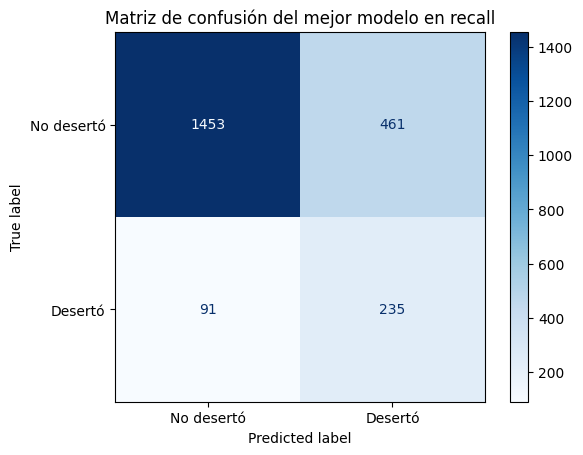

In [14]:
pipeline = Pipeline([
    ('imputer', im.make_imputer()),
    ('scaler', sc.make_scaler()),
    ('encoder', enc.make_encoder()),
    ('classifier', LogisticRegression(penalty='l1', 
                                      solver='liblinear',
                                      C=0.0569,
                                      class_weight={0: 0.06458345553013861, 1: 0.3974312699272093}))
]).set_output(transform='pandas')

model = pipeline.fit(X_train, y_train)
print(f"Mejor modelo: \n{model}\n----")

y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['No desertó', 'Desertó']

Display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

Display.plot(cmap=plt.cm.Blues)
plt.title(f'Matriz de confusión del mejor modelo en recall')

In [10]:
coefs = pd.DataFrame(model.named_steps['classifier'].coef_, columns=model.named_steps['encoder'].get_feature_names_out()).T
coefs.rename({0: 'value'}, axis=1, inplace=True)

/tmp/ipykernel_258889/4266057377.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  coefs.sort_values(by='value', ascending=False)[coefs.value != 0.0].plot(kind='bar')


<Axes: >

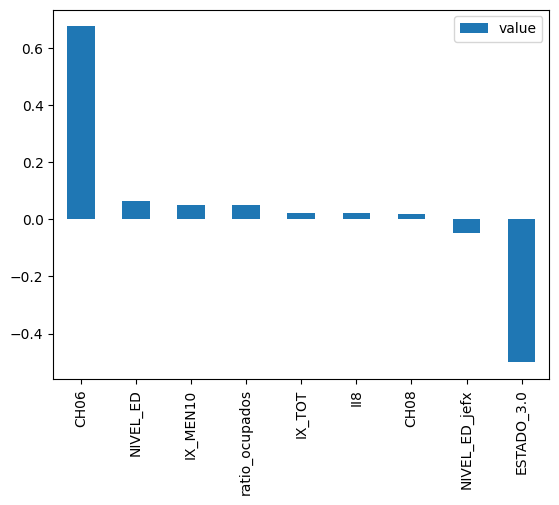

In [11]:
coefs.sort_values(by='value', ascending=False)[coefs.value != 0.0].plot(kind='bar')